## Data Preperation

In [ ]:
import nltk

nltk.download("punkt")
nltk.download("stopwords")
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import pandas as pd
import re
import random
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import gensim.corpora as corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.corpora.dictionary import Dictionary
from google.colab import files
from sklearn.decomposition import PCA
from sklearn import feature_extraction
from nltk.tokenize import word_tokenize
from sklearn import utils

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Import Dataset

In [ ]:
def import_dataset():
  try:
    src = list(files.upload().values())[0]
  except:
    print("no file selected")

In [ ]:
COLUMNS_NAMES = ["target", "ids", "text"]
stop_words = stopwords.words('english')

def get_prepared_data(text,rm_stop_words=True, stemming=True, lemmatisation=True):
    sentences = []
    # Create an empty DataFrame which will hold our data set.
    for words in text:
        words = re.sub('(?:\s)http[^, ]*|\d', '', words)
        words = words.split(" ")
        
        # Clean the data remove: (numbers, special characters) and make words in lower case.
        cleaned_words = [''.join(ch for ch in word if ch.isalnum()).lower() for word in words if re.match("\w", word)]

        # Remove stopwords if needed
        if rm_stop_words:
            cleaned_words = [word for word in cleaned_words if word not in stop_words]

        # Do stemming if needed
        if stemming:
            ps = PorterStemmer()
            cleaned_words = [ps.stem(word) for word in cleaned_words]

        # Do lemmatisation if needed
        if lemmatisation:
            lem = WordNetLemmatizer()
            cleaned_words = [lem.lemmatize(word) for word in cleaned_words]
        sentences.append(' '.join(cleaned_words))
    return sentences

## Text Extraction

TF-IDF Transformer

In [ ]:
def tf_idf(corpus, ngram_range=(1, 2)):
    transformer = feature_extraction.text.TfidfVectorizer(ngram_range=ngram_range, max_features=100000)
    transformer.fit(corpus)
    return transformer


PCA Transformer

In [ ]:
def pca_transformation(dimensions,corpus):
  pca = PCA(dimensions)
  return pca.fit_transform(corpus)

## Run the Project 

## Import Dataset

Import Dataset

In [ ]:
import_dataset()

Saving training.1600000.processed.noemoticon.csv to training.1600000.processed.noemoticon.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_cols = ["target", "ids", "date", "flag", "user", "text"]
dataset = pd.read_csv('/content/drive/MyDrive/training.1600000.processed.noemoticon.csv', header=None, encoding='ISO-8859-1' ,  names=dataset_cols)

In [ ]:
dataset.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


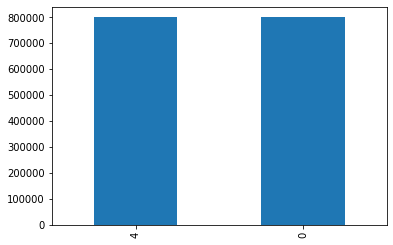

In [ ]:
dataset['target'].value_counts().plot(kind='bar')

In [ ]:
dataset = dataset[["target", "ids", "text"]]
datasetnew = dataset.sample(frac=1)
sample = datasetnew.head(10000)
sample['text'] = get_prepared_data(text=sample['text'])



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
Model_name = []
Model_performances = []

In [ ]:
from sklearn.preprocessing import LabelEncoder
y = sample['target']
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sample['text'], y, test_size = 0.20, random_state = 0)

In [ ]:
tf_idf = tf_idf(X_train)
X_train_tf_idf = tf_idf.fit_transform(X_train)
X_test_tf_idf = tf_idf.transform(X_test)

## Confusion Matrix function

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
def CM(y_test, y_pred):
      accuracy = accuracy_score(y_test, y_pred)
      print("The accuracy = ",accuracy)
      fig, ax = plt.subplots()
      sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True, ax=ax)
      ax.set_title('Confusion Matrix')
      ax.set_ylabel('Real Value')
      ax.set_xlabel('Predicted Value')

      plt.show()
      print(classification_report(y_pred , y_test))
      


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
import joblib
Model_name = []
Model_Score = []
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train_tf_idf, y_train)
# save the model to disk
filename = 'LR_model.sav'
joblib.dump(classifier, filename)
y_pred = classifier.predict(X_test_tf_idf)
Model_performances.append(y_pred)

The accuracy =  0.7295


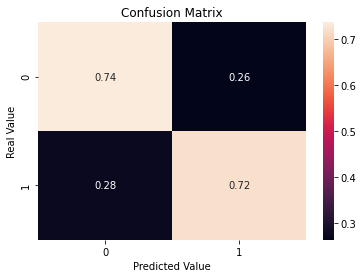

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1028
           1       0.72      0.72      0.72       972

    accuracy                           0.73      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.73      0.73      0.73      2000



In [ ]:
CM(y_test,y_pred)
Model_name.append("Linera Regression")
Model_Score.append(accuracy_score(y_test,y_pred))

## Trees 

The accuracy =  0.674


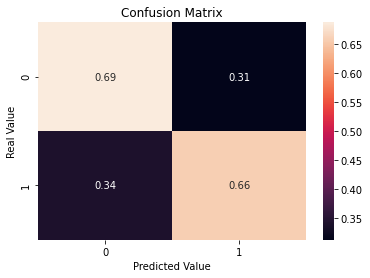

              precision    recall  f1-score   support

           0       0.69      0.68      0.68      1039
           1       0.66      0.67      0.66       961

    accuracy                           0.67      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       0.67      0.67      0.67      2000



In [ ]:
from sklearn import tree
DecisionTreeClassifier_Model = tree.DecisionTreeClassifier()
DecisionTreeClassifier_Model  = DecisionTreeClassifier_Model .fit(X_train_tf_idf, y_train)
filename = 'DecisionTreeClassifier_Model.sav'
joblib.dump(DecisionTreeClassifier_Model, filename)
y_pred = DecisionTreeClassifier_Model.predict(X_test_tf_idf)
Model_performances.append(y_pred)
Model_name.append("DecisionTree Classifier_Model")
Model_Score.append(accuracy_score(y_test,y_pred))
CM(y_test,y_pred)

## BERT

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text

In [ ]:
!pip install -q tf-models-official

In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [ ]:
# import pandas as pd

# text = []
# label = []
# for text_batch, label_batch in train_ds.take(1):
#   for i in range(50000):
#     text.append(text_batch.numpy()[i])
#     label.append(label_batch.numpy()[i])
    
# data = {'Text': text, 'label': label}  
# df = pd.DataFrame(data)  


In [ ]:
# df.shape

(0, 2)

In [ ]:
# df.head()

,Text,label
0,"(tf.Tensor(b'Silent Night, Deadly Night 5 is t...","(tf.Tensor(0, shape=(), dtype=int32), tf.Tenso..."
1,"(tf.Tensor(b'Silent Night, Deadly Night 5 is t...","(tf.Tensor(0, shape=(), dtype=int32), tf.Tenso..."
2,"(tf.Tensor(b'Silent Night, Deadly Night 5 is t...","(tf.Tensor(0, shape=(), dtype=int32), tf.Tenso..."
3,"(tf.Tensor(b'Silent Night, Deadly Night 5 is t...","(tf.Tensor(0, shape=(), dtype=int32), tf.Tenso..."
4,"(tf.Tensor(b'Silent Night, Deadly Night 5 is t...","(tf.Tensor(0, shape=(), dtype=int32), tf.Tenso..."


In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262903  0.99280983 -0.18611853  0.3667385   0.15233739  0.6550446
  0.9681154  -0.9486271   0.00216157 -0.9877732   0.06842728 -0.97630596]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946295  0.34321263  0.33231527 ...  0.2130087   0.71020836
  -0.05771071]
 [-0.2874208   0.31981027 -0.23018518 ...  0.5845508  -0.21329744
   0.7269212 ]
 [-0.66157013  0.6887687  -0.8743292  ...  0.10877226 -0.26173285
   0.47855547]
 ...
 [-0.22561097 -0.2892568  -0.07064426 ...  0.47566074  0.83277184
   0.40025318]
 [-0.29824227 -0.27473107 -0.05450526 ...  0.488498    1.0955358
   0.18163362]
 [-0.4437815   0.00930744  0.07223801 ...  0.17290124  1.1833242
   0.07898009]]


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.63793993]], shape=(1, 1), dtype=float32)


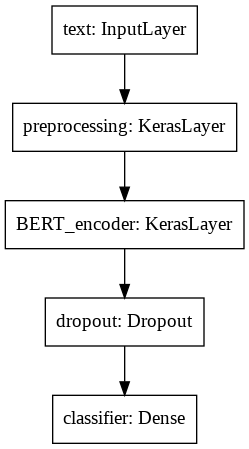

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/3
625/625 [==============================] - 169s 262ms/step - loss: 0.4676 - binary_accuracy: 0.7568 - val_loss: 0.3794 - val_binary_accuracy: 0.8382
Epoch 2/3
625/625 [==============================] - 159s 255ms/step - loss: 0.3224 - binary_accuracy: 0.8555 - val_loss: 0.3605 - val_binary_accuracy: 0.8424
Epoch 3/3
625/625 [==============================] - 159s 255ms/step - loss: 0.2506 - binary_accuracy: 0.8942 - val_loss: 0.3819 - val_binary_accuracy: 0.8458


In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 92s 117ms/step - loss: 0.3656 - binary_accuracy: 0.8531
Loss: 0.36556562781333923
Accuracy: 0.8531200289726257


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


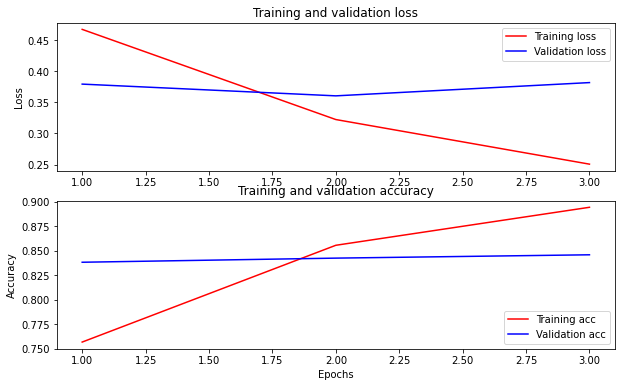

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'imdb'
saved_model_path = './'

classifier_model.save(saved_model_path, include_optimizer=True)

## K-mean cluster

In [ ]:
from sklearn.cluster import MiniBatchKMeans , KMeans
import numpy as np

In [ ]:
def kmeans_fit(data,clusters):
  return KMeans(n_clusters = clusters, init = 'k-means++').fit(data)

In [ ]:
def kmeans_elbow_method(step,max_clusters,data):
  iters = range(2,max_clusters+1,step)
  errors = {'elbow':[],'model':[]}
  for i in iters:
    model = kmeans_fit(data,i)
    errors['elbow'].append(model.inertia_)
    errors['model'].append(model)
  return errors

In [ ]:
def elbow_plot(step,max_clusters,clusters_error):
  iters = range(2,max_clusters+1,step)
  f, ax = plt.subplots(1, 1)
  ax.plot(iters, clusters_error, marker='o')
  ax.set_xlabel('Cluster Centers')
  ax.set_xticks(iters)
  ax.set_xticklabels(iters)
  ax.set_ylabel('SSE')
  ax.set_title('SSE by Cluster Center Plot')

In [ ]:
def plot_clusters(data,model):
  lables = model.fit_predict(data)
  plt.figure(figsize=(10,10))
  plt_lables = np.unique(lables)
  for i in plt_lables:
    plt.scatter(data[lables == i,0],data[lables == i,1],label = i)  
  plt.xlabel([])
  plt.xlabel('PC1')
  plt.ylabel('PC2')
  plt.legend()
  plt.show()

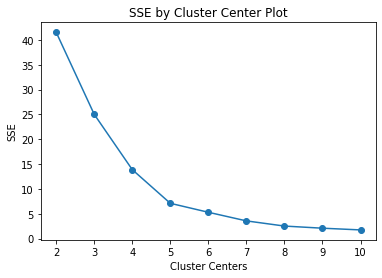

In [ ]:


from sklearn.decomposition import TruncatedSVD
errors = []
clf = TruncatedSVD(100)
#tf_idf = tf_idf()
data = tf_idf.fit_transform(sample['text'])
data = clf.fit_transform(data)
data = pca_transformation(2,data)
err = kmeans_elbow_method(1, 10,data)
errors.append(err)
elbow_plot(1, 10,err['elbow'])

In [ ]:
for index , error in enumerate(errors):
  silhouette = []
  kappa = []
  tf_idf = tf_idf(dataset['text'])
  X_train_tf_idf = tf_idf.fit_transform(dataset['text'])
  data = pca_transformation(pca_n,data)
  for m in error['model']:
    err = perform_evaluation(m,data,df['book_id'])
    silhouette.append(err['silhouette'])
    kappa.append(err['kappa'])
  error_analysis_plot("Kmeans with "+trans[index],"Silhouette",silhouette,range(2, 11))
  error_analysis_plot("Kmeans with "+trans[index],"Kappa",kappa,range(2, 11))


TypeError: ignored

In [ ]:
from sklearn.metrics import silhouette_score
model = kmeans_fit(data, 4)
score = silhouette_score(data, model.labels_, metric='euclidean')
print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.889


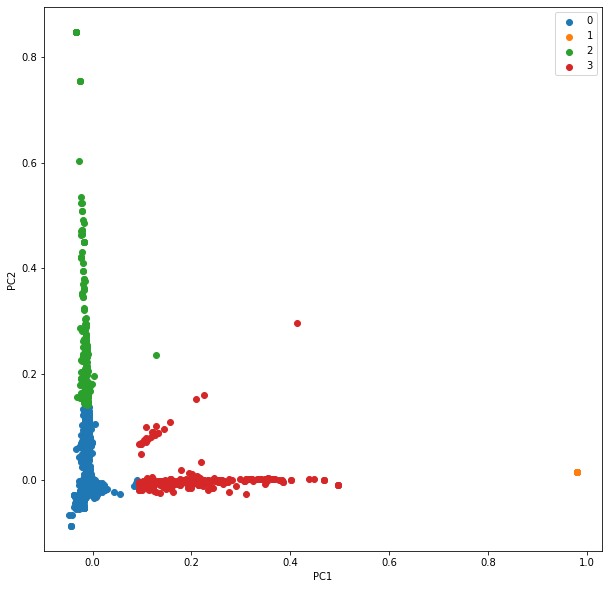

In [ ]:
plot_clusters(data,model)

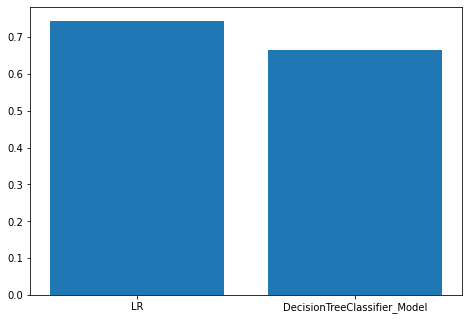

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(Model_name , Model_Score)
plt.show()

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression

train_sizes, train_scores, valid_scores = learning_curve(
    LogisticRegression(random_state = 0), X_train_tf_idf, y_train, train_sizes=[50, 80, 110], cv=5)

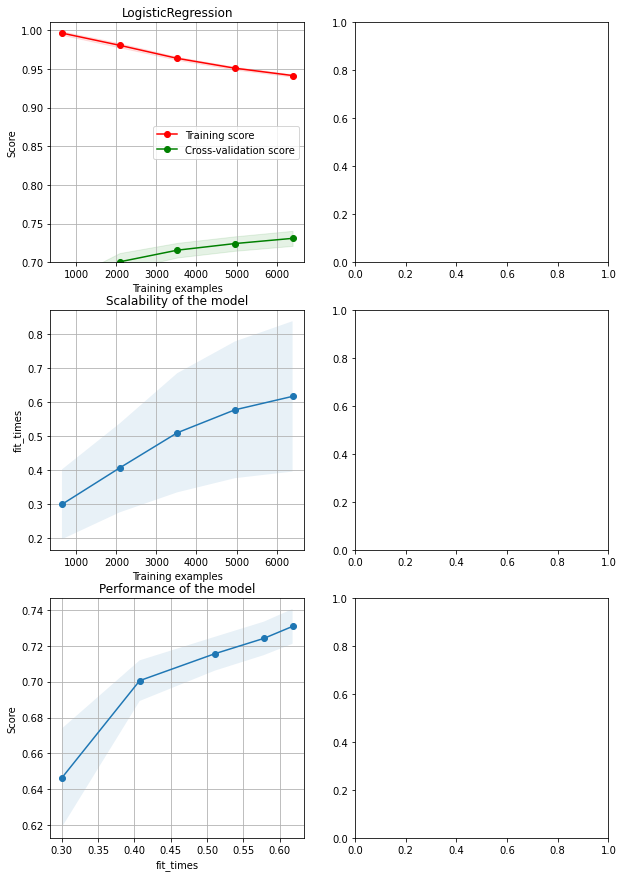

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "LogisticRegression"

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = LogisticRegression(random_state = 0)
plot_learning_curve(estimator,title, X_train_tf_idf, y_train, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)
plt.show()

KeyboardInterrupt: ignored

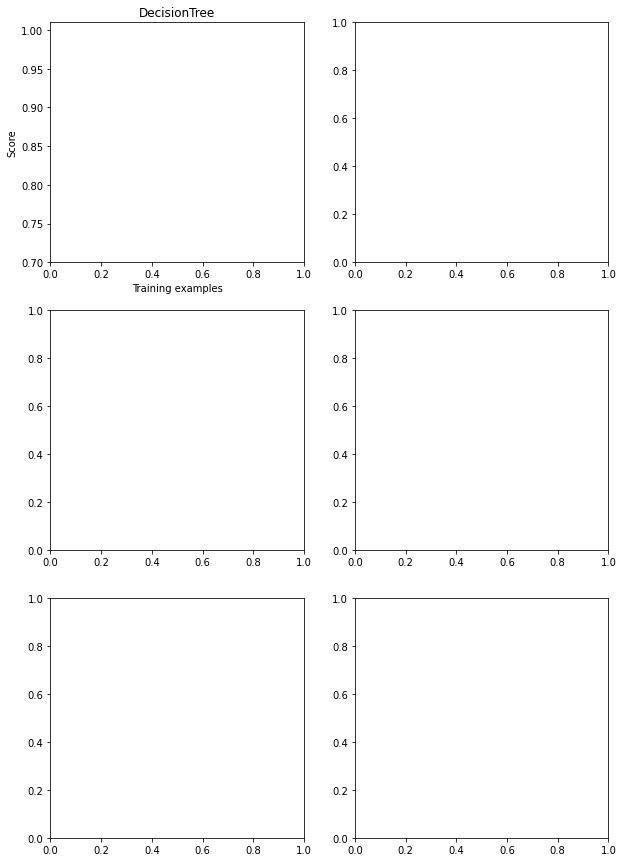

In [ ]:
from sklearn import tree
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
title = "DecisionTree"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = tree.DecisionTreeClassifier()
plot_learning_curve(estimator,title, X_train_tf_idf, y_train, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)
plt.show()

Error Analysis 


In [ ]:
def classification_error_analysis(predicted,actual,test_data):
  text = []
  wrong = []
  for i in range(0,len(predicted)):
    if predicted[i] != actual[i]:
      text.append([test_data[i]])
  all_text = sum(text,[])
  converted = []

  for i in all_text:
    converted.append(i.split())

  converted = sum(converted,[])
  counter = Counter(converted)

  most_occur = counter.most_common(10)
  return list(map(list, zip(*most_occur)))

In [ ]:
from sklearn.mixture import GaussianMixture
def Gaussian_mixture(data,components):
  return GaussianMixture(n_components=components).fit(data)


In [ ]:
def pca_transformation(dimensions,data):
  pca = PCA(dimensions)
  return pca.fit_transform(data)

In [ ]:
from collections import Counter 

KeyError: ignored

In [ ]:
def error_analysis(title,x,y):
  plt.title(title)
  plt.bar(x,y)
  plt.show()

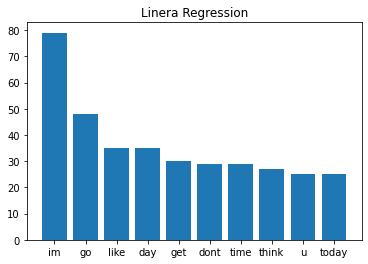

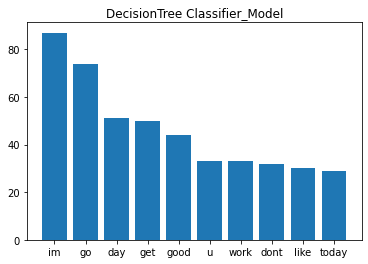

In [ ]:
for i in range(0,len(Model_performances)):
    x,y = classification_error_analysis(Model_performances[i],y_test,X_test.tolist())
    error_analysis(Model_name[i],x,y)

In [ ]:
Model_performances[0][0:50]

array([1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0])